# Задание

Вам предстоит поработать с данными о стабильности белков (`tm`). Нужно по последовательности белка и по `pH` предсказывать стабильность. Так как это дополнительное задание, то комментариев и подробного плана не будет, вам нужно максимально показать свои знания и постараться добиться наилучшего качества.

Небольшой план для начала:

1. Провести небольшой EDA, найти возможные выбросы и понять, в чем может быть дело.
2. Придумать, как закодировать аминокислотные последовательности в числовые векторы.
3. Разделить данные на `train` и `test` (подумать над правильной стратегией разбиения).
4. Используя кросс-вадидацию подобрать наилучшую модель на тренировочных данных.
5. Обучить лучшую модель на всех тренировочных данных.
5. Протестировать лучшую модель на тестовых данных.

Оформить подробный отчет в виде ноутбука. Постарайтесь воспользоваться всеми техниками, которые мы прошли в курсе.

*Так как текущее задание в довольно свободной форме, то четких критериев оценки нет. Если минимально проследовать вышеуказанным рекомендациям, то можно получить до **20 баллов**. Максимально за это задание можно получить **40***.

In [1]:
import pandas as pd

In [2]:
data_filename = "data.csv"
data_path = data_filename

In [3]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [4]:
data.shape

(31390, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31390 entries, 0 to 31389
Data columns (total 4 columns):
protein_sequence    31390 non-null object
pH                  31104 non-null float64
data_source         28043 non-null object
tm                  31390 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB


## EDA

In [6]:
data.isna().sum()

protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64

В данных есть пропущенные значения. Значение pH напрямую влияет на стабильность белка, поэтому возьмем только данные для которых есть значения pH. 

In [7]:
data.pH.unique()

array([ 7.  ,  5.  ,  7.5 ,   nan,  7.4 , 48.4 , 49.  , 55.6 ,  6.2 ,
        5.5 ,  6.3 ,  2.  ,  8.5 ,  3.  ,  6.8 ,  6.4 ,  6.6 ,  6.7 ,
        6.5 ,  4.5 ,  8.  ,  7.3 ,  7.2 ,  8.4 ,  8.1 ,  9.6 ,  5.9 ,
        6.  ,  4.  ,  3.5 ,  4.2 ,  5.1 ,  3.6 ,  7.1 ,  7.8 ,  9.  ,
        3.2 ,  2.5 ,  2.8 ,  5.2 ,  5.4 ,  5.8 ,  7.7 ,  7.6 , 10.  ,
        8.2 ,  2.7 ,  2.9 ,  3.1 , 64.9 ,  3.14,  2.53,  2.3 ,  2.2 ,
        2.81,  8.25,  9.9 ,  9.5 , 10.4 ,  9.08,  8.7 ,  3.7 , 39.  ,
        4.6 ,  4.4 ,  5.35,  5.7 ,  9.2 ,  5.38,  5.28,  6.9 ,  5.42,
        5.3 ,  6.1 ,  9.7 ,  8.6 ,  4.8 ,  6.78,  5.31,  3.02,  4.9 ,
        4.3 ,  5.45,  3.01,  3.3 ,  3.8 ,  2.4 ,  2.84,  2.34,  4.7 ,
        2.1 ,  3.9 ,  2.02,  2.83,  2.03,  2.86,  1.99,  8.3 , 53.4 ,
        3.16,  2.94,  9.75,  3.15,  3.07,  3.04,  3.25,  3.21,  2.98,
        3.19,  4.1 ,  5.6 ,  3.75,  4.75,  4.25, 11.  , 10.3 ])

In [8]:
data1 = data.dropna(subset=['pH'])
data.shape[0] - data1.shape[0]

286

In [9]:
print(data1.describe())

                 pH            tm
count  31104.000000  31104.000000
mean       6.892339     49.150608
std        1.612225     14.044705
min        1.990000     -1.000000
25%        7.000000     42.100000
50%        7.000000     48.100000
75%        7.000000     53.800000
max       64.900000    130.000000


Интервал значений pH и Tm вызывает сомнения. 
* Интервал температуры плавления неожиданный. Не знаю метода исследования, могу предположить, что измерение проводилось в водной среде при нормальном давлении, поэтому отрицательные значения и значения выше 100 град. убираем. 
* pH может быть более 14, однако врядли в эксперименте с белками использовался настолько щелочной буффер. Поэтому будем учитывать значения pH до 14-ти.
Беру на себя ответственность убрать экспериментальные данные с сомнительными параметрами.

In [10]:
data2 = data1.drop(data1[(data1.pH > 14) | (data1.tm < 0) | (data1.tm > 100)].index)
data2.describe()

,pH,tm
count,31067.000000,31067.000000
mean,6.850902,49.179206
std,0.859405,13.953180
min,1.990000,0.000000
25%,7.000000,42.100000
50%,7.000000,48.100000
75%,7.000000,53.800000
max,11.000000,99.000000


In [11]:
! pip3 install matplotlib

/usr/bin/sh: 1: pip3: not found


Теперь значения параметров похожи на реальные.

In [12]:
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5,10))
ax0.set_title('pH histogramm')
ax0.hist(data2.pH, bins=100)
ax1.set_title('pH histogram with frequency lower than 700') 
ax1.hist(data2.pH, bins=100)
ax1.set_ylim([0,700])
ax2.set_title('Melting temperature histogram')
ax2.hist(data2.tm, bins=100)
plt.show()

По гистограме присутствует большое кол-во результатов при нейтральном pH (~7). Так же есть много наблюдений от 2 до 10. Думаю получится построить модель, которая хорошо сможет предказывать в этом регионе.
Для температуры плавления, наблюдается две моды. Попробуем посмотреть на температуру плавления на белках при нейтральном pH.

,pH,tm
count,27641.000000,27641.000000
mean,7.011829,49.722463
std,0.089409,13.149867
min,6.500000,0.000000
25%,7.000000,42.700000
50%,7.000000,48.100000
75%,7.000000,53.400000
max,7.500000,99.000000


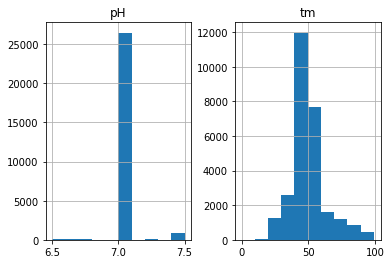

In [13]:
data3 = data2.drop(data2[(data2.pH < 6.5) | (data2.pH > 7.5)].index)
data3.hist()
data3.describe()

Один пик наблюдается при нейтральном pH. Проверем при каком pH наблюдается второй.

,pH,tm
count,1523.000000,1523.000000
mean,6.390164,24.977938
std,1.573140,0.201503
min,2.000000,23.000000
25%,5.500000,25.000000
50%,7.000000,25.000000
75%,7.400000,25.000000
max,9.000000,26.000000


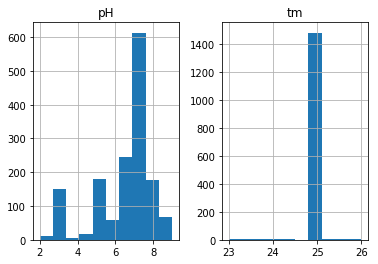

In [14]:
data4 = data2.drop(data2[(data2.tm < 23) | (data2.tm > 26)].index)
data4.hist()
data4.describe()

Я хотел увидеть иное, но ожидаемый результат. второй пик тоже соответсвует нейтральному pH. Вимо дело в самой природе белка. Мб в длине первичной структры.

In [15]:
data3.columns

Index(['protein_sequence', 'pH', 'data_source', 'tm'], dtype='object')

In [16]:
print('First peak')
print(data3['protein_sequence'].str.len().mean())
print(data3['protein_sequence'].str.len().std())
print('Second peak')
print(data4['protein_sequence'].str.len().mean())
print(data4['protein_sequence'].str.len().std())

First peak
470.1429760138924
666.8817348661364
Second peak
503.06369008535785
2267.1511592722545


Нет. дело не в длине. Внутри групп они совсем разные встречаются ._. 
Пропустим этот вопрос, он второстепенный

In [17]:
data2.to_csv('data2.csv', sep='\t')

## Representation of amino acids
Есть несколько вариантов представить последовательность мномеров в числовом виде.
 * “one-hot encoding”
 * the BLOck SUbstitution Matrix (BLOSUM)
 * the principal components score Vectors of Hydrophobic, Steric, and Electronic properties (VHSE8).
И есть много статей по сравнению и новым предложениям. Среди пары пакетов на питон нашел [seqvec](https://pypi.org/project/seqvec/) выглядит убедительно с 94-мя звездами.

Однако не получилось запустить из-за проблемы со скачиванием. Он мне выдал ошибку на уровне установки необходимых модулей. А в одном файле и не нашел функци... Расстроился из-за потраченного вечера. Починить мне не удалось.

In [17]:
! pip install bio-embeddings

  Could not find a version that satisfies the requirement bio-embeddings (from versions: )
No matching distribution found for bio-embeddings
You are using pip version 9.0.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
! pip install seqvec

  Could not find a version that satisfies the requirement seqvec (from versions: )
No matching distribution found for seqvec
You are using pip version 9.0.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Пробовал из их ноутбука

In [19]:
pwd

'/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main'

Работаю с компа Ильи

In [20]:
cd tool

[Errno 2] No such file or directory: 'tool'
/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main


In [21]:
from tool.bio_embeddings.embed.seqvec_embedder import SeqVecEmbedder
embedder = SeqVecEmbedder()

target_sequence = "MALLHSARVLSGVASAFHPGLAAAASARASSWWAHVEMGPPDPILGVTEAYKRDTNSKKMNLGVGAYRDDNGKPYVLPSVRKAEAQIAAKGLDKEYLPIGGLAEFCRASAELALGENSEVVKSGRFVTVQTISGTGALRIGASFLQRFFKFSRDVFLPKPSWGNHTPIFRDAGMQLQSYRYYDPKTCGFDFTGALEDISKIPEQSVLLLHACAHNPTGVDPRPEQWKEIATVVKKRNLFAFFDMAYQGFASGDGDKDAWAVRHFIEQGINVCLCQSYAKNMGLYGERVGAFTVICKDADEAKRVESQLKILIRPMYSNPPIHGARIASTILTSPDLRKQWLQEVKGMADRIIGMRTQLVSNLKKEGSTHSWQHITDQIGMFCFTGLKPEQVERLTKEFSIYMTKDGRISVAGVTSGNVGYLAHAIHQVTK"

embedding = embedder.embed(target_sequence)

ImportError: No module named 'tool'

и в модуле в файле commands я не нашел функции elmo. Решил не разбираться дальше...

Зато нашел клевое пособие [тут](https://stephanheijl.com/protein_sequence_ml.html) еще и с теорией. Попробуем его

In [22]:
pwd

'/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main'

In [23]:
cd ..

/mnt/c/Users/Ilya/PycharmProjects


In [24]:
! git clone https://github.com/tbepler/protein-sequence-embedding-iclr2019.git

Cloning into 'protein-sequence-embedding-iclr2019'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 54 (delta 9), reused 6 (delta 6), pack-reused 38
Receiving objects: 100% (54/54), 53.57 KiB | 543.00 KiB/s, done.
Resolving deltas: 100% (17/17), done.


In [25]:
import sys
sys.path.append("C:\\Users\\Ilya\\PycharmProjects\\BI_Stat_22-23-main\\additional_task\\protein-sequence-embedding-iclr2019")

In [26]:
print(sys.path)

['', '/root/miniconda3/envs/py35/lib/python35.zip', '/root/miniconda3/envs/py35/lib/python3.5', '/root/miniconda3/envs/py35/lib/python3.5/plat-linux', '/root/miniconda3/envs/py35/lib/python3.5/lib-dynload', '/root/miniconda3/envs/py35/lib/python3.5/site-packages', '/root/miniconda3/envs/py35/lib/python3.5/site-packages/IPython/extensions', '/root/.ipython', 'C:\\Users\\Ilya\\PycharmProjects\\BI_Stat_22-23-main\\additional_task\\protein-sequence-embedding-iclr2019', 'C:\\Users\\Ilya\\PycharmProjects\\BI_Stat_22-23-main\\additional_task\\protein-sequence-embedding-iclr2019']


In [27]:
import numpy as np
# Import data from protein sequence embedding repository.
from src.alphabets import Uniprot21
from src.utils import pack_sequences, unpack_sequences
from torch.nn.utils.rnn import PackedSequence
import torch

ImportError: No module named 'src'

In [28]:
u21 = Uniprot21()

def embed_sequences(sequences, lm_embed):
    """ Embed sequences
    :param sequences: An iterable containing uppercase sequences strings.
    :param lm_embed: A pytorch embedding model that accepts encodeded
                     and produces matrices of size <seqlen>×<vecsize>.
    :param sequences: An iterable containing the position of each variant.
    :param sequences: An iterable with position offsets for each variant.
    :returns: A dictionary containing the average vector, the last vector and the vector of the variant type.
    """
    enc_sequences = [u21.encode(bytes(seq, "ascii")) for seq in sequences]
    enc_sequences = [torch.from_numpy(x_).long() for x_ in enc_sequences]
    with torch.no_grad():
        data, order = pack_sequences(enc_sequences)
        z = lm_embed(data)
        embedded_sequences = unpack_sequences(z, order)

    avg_vec = np.array([seq.mean(0).detach().cpu().numpy() for seq in embedded_sequences])

    assert not np.isnan(avg_vec).any()


    return {"avg": avg_vec}

NameError: name 'Uniprot21' is not defined

In [29]:
target_sequence = "MALLHSARVLSGVASAFHPGLAAAASARASSWWAHVEMGPPDPILGVTEAYKRDTNSKKMNLGVGAYRDDNGKPYVLPSVRKAEAQIAAKGLDKEYLPIGGLAEFCRASAELALGENSEVVKSGRFVTVQTISGTGALRIGASFLQRFFKFSRDVFLPKPSWGNHTPIFRDAGMQLQSYRYYDPKTCGFDFTGALEDISKIPEQSVLLLHACAHNPTGVDPRPEQWKEIATVVKKRNLFAFFDMAYQGFASGDGDKDAWAVRHFIEQGINVCLCQSYAKNMGLYGERVGAFTVICKDADEAKRVESQLKILIRPMYSNPPIHGARIASTILTSPDLRKQWLQEVKGMADRIIGMRTQLVSNLKKEGSTHSWQHITDQIGMFCFTGLKPEQVERLTKEFSIYMTKDGRISVAGVTSGNVGYLAHAIHQVTK"

model = torch.load('C:\\Users\\Ilya\\PycharmProjects\\BI_Stat_22-23-main\\additional_task\\pretrained_models\\ssa_L1_100d_lstm3x512_lm_i512_mb64_tau0.5_p0.05_epoch100.sav')
model = model.eval()
lm_embed = model.embedding  # Use the full model
vec = embed_sequences(target_sequence, lm_embed)
print(vec)

NameError: name 'torch' is not defined

Вышла ошибка
AttributeError: 'LSTM' object has no attribute '_flat_weights'
нужно поставить более раннюю версию torch 1.3.1. А для неё нужна ранняя версия Python 3.5. А эта версия не поддерживается pycharm.
\*крики боли\*

Переходим на ubuntu и jupyter notebook

In [30]:
! python -V

Python 3.5.4 :: Anaconda, Inc.


In [31]:
! pip install torch==1.3.1

You are using pip version 9.0.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
pwd

'/mnt/c/Users/Ilya/PycharmProjects'

In [2]:
import sys
import torch
sys.path.append('/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main/additional_task/protein-sequence-embedding-iclr2019')

In [3]:
import numpy as np
# Import data from protein sequence embedding repository.
from src.alphabets import Uniprot21
from src.utils import pack_sequences, unpack_sequences
from torch.nn.utils.rnn import PackedSequence

In [164]:
u21 = Uniprot21()

def embed_sequences(sequences, lm_embed):
    """ Embed sequences
    :param sequences: An iterable containing uppercase sequences strings.
    :param lm_embed: A pytorch embedding model that accepts encodeded
                     and produces matrices of size <seqlen>×<vecsize>.
    :returns: A numpy containing the average vector.
    """
    if type(sequences) is str:
        sequences = [sequences]
    enc_sequences = [u21.encode(bytes(seq, "ascii")) for seq in sequences]
    enc_sequences = [torch.from_numpy(x_).long() for x_ in enc_sequences]
    with torch.no_grad():
        data, order = pack_sequences(enc_sequences)
        z = lm_embed(data)
        embedded_sequences = unpack_sequences(z, order)

    avg_vec = torch.stack(embedded_sequences).mean(dim=1)
    #avg_vec = np.array([seq.mean(0).detach().cpu().numpy() for seq in embedded_sequences])

    assert not torch.isnan(avg_vec).any()

    return avg_vec


In [168]:
target_sequence = ["MALLHSARVLSGVASAFHPGLAAAASARASSWWAHVEMGPPDPILGVTEA",
                   "YKRDTNSKKMNLGVGAYRDDNGKPYVLPSVRKAEAQIAAKGLDKEYLPIGG"]


model = torch.load('/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main/additional_task/pretrained_models/ssa_L1_100d_lstm3x512_lm_i512_mb64_tau0.5_p0.05_epoch100.sav');
model = model.eval()
#model = model.cuda()
lm_embed = model.embedding;  # Use the full model

/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'src.models.sequence.BiLM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessi

In [169]:
vec = embed_sequences(target_sequence[0], lm_embed)
print(vec)

tensor([[-3.2425e+00,  4.5937e+00, -3.8653e+00,  4.6651e+00,  1.6019e+00,
          3.8611e+00,  1.2008e+00, -3.8935e+00, -3.9621e+00,  3.3860e+00,
          1.2109e+00, -3.3111e+00,  2.2808e+00,  3.2556e+00, -3.6610e+00,
          1.7422e+00, -1.7033e+00,  1.1217e+00, -2.6201e+00, -2.9795e+00,
         -3.0179e+00,  2.1652e+00,  4.0683e+00, -4.2595e+00,  4.6799e-02,
          2.0584e+00,  3.0018e+00, -1.8939e+00,  1.4667e+00,  1.4737e+00,
          2.7923e+00, -1.9406e+00,  2.5397e+00,  2.2533e+00, -1.4330e+00,
          2.8115e+00,  3.5667e+00,  2.7223e+00,  2.5616e+00, -1.7570e-01,
         -3.3873e+00, -7.0736e-01,  4.6578e+00, -4.1627e+00, -1.6303e+00,
         -3.8228e+00, -4.6068e-01,  4.0802e-03,  2.4806e+00, -3.5758e+00,
          1.2549e+00,  3.4813e+00, -2.5667e+00, -2.2252e+00, -3.2783e+00,
          1.9454e+00, -1.9833e+00, -4.2895e+00,  1.2887e+00,  2.1970e+00,
         -3.3702e+00, -1.6236e+00,  4.0065e+00, -4.3976e+00, -1.4079e+00,
         -1.5099e+00, -2.4780e+00, -1.

Работает :*)

In [170]:
import pandas as pd

data2 = pd.read_csv('data2.csv', sep='\t')
data2.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [171]:
# модуль красиво показывает время выполнения ячейки
! pip install tqdm 

You are using pip version 9.0.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


загрузим тестовые данные 500 последовательностей.

In [175]:
from tqdm import tqdm

#так как она показала себя лучше. Там была задача кластеризации, но думаю подойдет.
# вектор состоит из средних значений и этот подход себя тоже лучше показал согласно пособию. (пособие выше после рыданий)

model = torch.load('/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main/additional_task/pretrained_models/ssa_L1_100d_lstm3x512_lm_i512_mb64_tau0.5_p0.05_epoch100.sav')
model = model.eval()
lm_embed = model.embedding

dict_id_protvec = []

for i in tqdm(range(0, 500), ncols=100, ascii=True, desc='Total'):
    try:
        seq = data2['protein_sequence'][i]
    except Exception:
        pass
    dict_id_protvec.append(embed_sequences(seq, lm_embed))

/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'src.models.sequence.BiLM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/py35/lib/python3.5/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessi

In [177]:
import torch

# Assuming your tensor is named "tensor_data"
tensor_data = dict_id_protvec  # Replace with your actual tensor

# Specify the file path where you want to save the tensor
file_path = "dict_id_protvec_500.pt"  # Replace with your desired file path and extension

# Save the tensor to file
torch.save(tensor_data, file_path)

In [ ]:
from tqdm import tqdm

# я выбрал модель согласно пособию, так как она показала себя лучше. Там была задача кластеризации, но думаю подойдет.
# вектор состоит из средних значений и этот подход себя тоже лучше показал согласно пособию. (пособие выше после рыданий)

model = torch.load('/mnt/c/Users/Ilya/PycharmProjects/BI_Stat_22-23-main/additional_task/pretrained_models/ssa_L1_100d_lstm3x512_lm_i512_mb64_tau0.5_p0.05_epoch100.sav')
model = model.eval()
lm_embed = model.embedding

dict_id_protvec_2 = {}

for i in tqdm(range(data2.shape[0]//2, data2.shape[0]+1), ncols=100, ascii=True, desc='Total'):
    try:
        seq = data2['protein_sequence'][i]
    except Exception:
        pass
    dict_id_protvec_2[str(data2['seq_id'][i])] = embed_sequences(seq, lm_embed)

## Загрузка данных

In [9]:
! pip install pandas
! pip install torch
! pip install tensorflow
! pip install -U scipy
! pip install numpy==1.18

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 38.6 MB/s eta 0:00:0000:01:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1130 lines of output]
      Running from numpy source directory.
      Cythonizing sources
      numpy/random/_bounded_integers.pxd.in has not changed
      numpy/random/_pcg64.pyx has not changed
      numpy/random/_generator.pyx has not changed
      numpy/random/_common.pyx has not changed
      numpy/random/_philox.pyx has not changed
      numpy/random/mtrand.pyx has not changed
      numpy/random/_bit_generator.pyx has not changed
      numpy/random/_sfc64.pyx has not changed
      numpy/random/_bounded_integers.pyx.in has not changed
      numpy/random/_mt19937.pyx has not changed
      Processing numpy/random/_bounded_inte

In [8]:
import pandas as pd
import torch
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

ModuleNotFoundError: No module named 'numpy.testing'

In [2]:
data2 = pd.read_csv('data2.csv', sep='\t')
data_seqvec=torch.load("dict_id_protvec_500.pt")

In [12]:
data_seqvec[0][0]

tensor([-1.7700,  2.4515, -1.6875,  3.6165,  0.6720,  1.8665, -0.5171, -3.2259,
        -2.7775,  2.2450,  1.2689, -4.3968,  2.4096,  2.4399, -3.4593, -0.2880,
         0.6614,  0.9571, -2.3643, -1.6456, -1.2891,  2.4051,  3.6060, -2.9275,
         2.4012,  1.6599,  2.1848, -1.1345,  0.3298, -1.0701,  2.6572, -1.8858,
         2.8921,  0.7950, -1.0018,  1.9551,  3.5279,  0.4127,  2.9736,  0.0993,
        -3.0007, -0.8243,  2.4667, -2.2320, -0.9414, -3.8365, -0.5141,  0.5437,
         2.1421, -3.4800, -0.0501,  2.9294, -2.2002, -0.7553, -3.2968,  2.4083,
        -1.3924, -2.1656, -0.0545,  2.9510, -1.3734, -0.6592,  1.3209, -3.4425,
        -1.4856, -1.5471, -2.8395, -0.7386, -2.0619,  0.7123,  2.1234, -0.6661,
         0.1092, -1.2595, -2.5378, -3.1347, -2.5562, -2.4392, -2.5689,  1.8397,
         4.5562, -1.9747,  2.2856, -1.0626,  1.0807,  1.6671,  2.3926, -3.8768,
         3.8776,  2.6067, -1.2363, -2.9501, -2.4370, -3.3410, -1.2126,  1.7269,
        -1.5267,  3.2561,  2.5006, -2.14

In [13]:
pH_values = data2['pH'][:500]
Tm_values = data2['tm'][:500]

protein_sequences_encoded = []
for seq in data_seqvec:
    protein_sequences_encoded.append(seq[0])

In [211]:
# Combine features into a single input matrix
X = np.column_stack((protein_sequences_encoded, pH_values))

# Convert the target variable to numpy array
y = np.array(Tm_values)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression with TensorFlow
lin_reg_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[X_train.shape[1]])
])
lin_reg_model.compile(optimizer='adam', loss='mean_squared_error')
lin_reg_model.fit(X_train, y_train, epochs=100, verbose=0)
lin_reg_y_pred = lin_reg_model.predict(X_test).flatten()

# Decision Trees
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
tree_y_pred = tree_model.predict(X_test)

# Random Forests
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_y_pred = forest_model.predict(X_test)

# Support Vector Machines (SVM)
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)

# Neural Networks with TensorFlow
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(X_train, y_train, epochs=100, verbose=0)
nn_y_pred = nn_model.predict(X_test).flatten()

# Model evaluation
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(model_name,":")
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print()

evaluate_model(y_test, lin_reg_y_pred, "Linear Regression (TensorFlow)")
evaluate_model(y_test, tree_y_pred, "Decision Trees")
evaluate_model(y_test, forest_y_pred, "Random Forests")
evaluate_model(y_test, svm_y_pred, "Support Vector Machines (SVM)")
evaluate_model(y_test, nn_y_pred, "Neural Networks (TensorFlow)")


ImportError: No module named 'tensorflow'